In [23]:
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras import models
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [221]:
TRAIN_DATA_DIR = 'data/final_ver8/train/'
#TEST_DATA_DIR = 'data/final_ver3/test/'

TRAIN_NEGATIVE_DATA_DIR = 'data/final_ver8/train_negative/'
#TEST_NEGATIVE_DATA_DIR = 'data/final_ver3/test_negative/'

train_fire_size = []
#test_fire_size = []

train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []
train_file = []

#test_X = []
#test_spectrograms = []
#test_mel_spectrograms = []
#test_mfccs = []
#test_y = []
#test_file = []

#pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
#pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))

TRAIN_DATA_DIR = 'data/ver1/train3/final_positive/'
TEST_DATA_DIR = 'data/ver1/test3/final_positive/'

TRAIN_NEGATIVE_DATA_DIR = 'data/ver1/train3/final_negative/'
TEST_NEGATIVE_DATA_DIR = 'data/ver1/test3/final_negative/'

In [25]:
def padding(a, i) :
    if (a.shape[1] >= i) :
        return a[:, 0:i]
    else :
        difference = i-a.shape[1]
        zeros = np.random.randint(difference+1)
        
        #print(zeros, difference-zeros)
        
        first = np.zeros((a.shape[0], zeros))
        second = np.zeros((a.shape[0], difference - zeros))
        
        new = np.hstack((first, a))
        new = np.hstack((new, second))
        
        return new

In [26]:
for fname in os.listdir(TRAIN_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        train_file.append(TRAIN_DATA_DIR + fname)
        wav, sr = librosa.load(TRAIN_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        train_mfccs.append(padded_mfcc)
        train_mel_spectrograms.append(padded_mel_spectrogram)
        train_y.append(1)
    except Exception as e:
        print(fname, e)
        raise

In [27]:
#np.max(train_fire_size)

for fname in os.listdir(TEST_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        test_file.append(TEST_DATA_DIR + fname)
        wav, sr = librosa.load(TEST_DATA_DIR + fname, sr=16000)
        
        #if(len(wav) > 20000) :
         #   wav = librosa.effects.time_stretch(wav, 1.5)
            
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        test_fire_size.append(len(mfcc[0]))
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        
        test_mfccs.append(padded_mfcc)
        test_mel_spectrograms.append(padded_mel_spectrogram)
        test_y.append(1)
    except Exception as e:
        print(fname, e)
        raise

In [28]:
for fname in os.listdir(TRAIN_NEGATIVE_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        train_file.append(TRAIN_NEGATIVE_DATA_DIR + fname)
        wav, sr = librosa.load(TRAIN_NEGATIVE_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        train_mfccs.append(padded_mfcc)
        train_mel_spectrograms.append(padded_mel_spectrogram)
        train_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

for fname in os.listdir(TEST_NEGATIVE_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        test_file.append(TEST_NEGATIVE_DATA_DIR + fname)
        wav, sr = librosa.load(TEST_NEGATIVE_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        
        padded_mfcc = padding(mfcc, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        test_mfccs.append(padded_mfcc)
        test_mel_spectrograms.append(padded_mel_spectrogram)
        test_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

print(len(train_fire_size))
print(np.max(train_fire_size))
print(np.mean(train_fire_size))

print(len(test_fire_size))
print(np.max(test_fire_size))
print(np.mean(test_fire_size))

In [29]:
train_mfccs = np.array(train_mfccs)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_y = np.array(train_y)
train_y = to_categorical(np.array(train_y))

#test_mfccs = np.array(test_mfccs)
#test_mel_spectrograms = np.array(test_mel_spectrograms)
#test_y = np.array(test_y)
#test_y = to_categorical(np.array(test_y))

print('train_mfccs', train_mfccs.shape)
print('train_mel_spectrograms', train_mel_spectrograms.shape)
print('train_y', train_y.shape)

#print('test_mfccs', test_mfccs.shape)
#print('test_mel_spectrograms', test_mel_spectrograms.shape)
#print('test_y', test_y.shape)

train_mfccs (72000, 20, 63)
train_mel_spectrograms (72000, 128, 63)
train_y (72000, 2)


In [30]:
train_X_ex = np.expand_dims(train_mfccs, -1)
#test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
#print('test X shape:', test_X_ex.shape)

train X shape: (72000, 20, 63, 1)


In [31]:
train_X_ex_mel = np.expand_dims(train_mel_spectrograms, -1)
#test_X_ex_mel = np.expand_dims(test_mel_spectrograms, -1)
print('train X shape:', train_X_ex_mel.shape)
#print('test X shape:', test_X_ex_mel.shape)

train X shape: (72000, 128, 63, 1)


In [32]:
np.save(os.path.join("data/dataset", "train_X.npy"), train_X_ex)
np.save(os.path.join("data/dataset", "train_X_mel.npy"), train_X_ex_mel)
np.save(os.path.join("data/dataset", "train_file.npy"), train_file)
np.save(os.path.join("data/dataset", "train_y.npy"), np.array(train_y))

#np.save(os.path.join("data/dataset", "test_X.npy"), test_X_ex)
#np.save(os.path.join("data/dataset", "test_X_mel.npy"), test_X_ex_mel)
#np.save(os.path.join("data/dataset", "test_file.npy"), test_file)
#np.save(os.path.join("data/dataset", "test_y.npy"), np.array(test_y))

In [245]:
all_X_ex = np.load(os.path.join('data/dataset_ver8', 'train_X.npy'))
all_X_ex_mel = np.load(os.path.join('data/dataset_ver8', 'train_X_mel.npy'))
all_file = np.load(os.path.join('data/dataset_ver8', 'train_file.npy'))
all_y = np.load(os.path.join('data/dataset_ver8', 'train_y.npy'))

#test_X_ex = np.load(os.path.join('data/dataset', 'test_X.npy'))
#test_X_ex_mel = np.load(os.path.join('data/dataset', 'test_X_mel.npy'))
#test_file = np.load(os.path.join('data/dataset', 'test_file.npy'))
#test_y = np.load(os.path.join('data/dataset', 'test_y.npy'))

train_X_ex, train_X_ex_mel, train_y, train_file = shuffle(train_X_ex, train_X_ex_mel, train_y, train_file, random_state=1523)
#test_X_ex, test_X_ex_mel, test_y, test_file = shuffle(test_X_ex, test_X_ex_mel, test_y, test_file, random_state=1523)

In [246]:
train_X_ex, validation_X_ex, train_X_ex_mel, validation_X_ex_mel, train_y, validation_y, train_file, validation_file =\
train_test_split(all_X_ex, all_X_ex_mel, all_y, all_file, test_size = 0.18, random_state=42)

In [247]:
len(train_X_ex)

5904

In [248]:
np.max(train_X_ex)

205.35385

In [249]:
np.mean(train_X_ex)

-10.165406

In [250]:
train_y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [254]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)


m=Flatten()(m)
m=Dense(32, activation='relu')(m)
op=Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 20, 63, 1)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 17, 60, 64)        1088      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 15, 64)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 3840)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                122912    
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 66        
Total params: 124,066
Trainable params: 124,066
Non-trainable params: 0
_______________________________________________

In [255]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('model/train_X_ex_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

model.compile(optimizer=optimizers.Adam(learning_rate=0.000001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_X_ex,
                    train_y,
                    epochs=400,
                    batch_size=32,
                    verbose=1,
                    validation_data=(validation_X_ex, validation_y),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/400
181/185 [============================>.] - ETA: 0s - loss: 6.8471 - accuracy: 0.5017
Epoch 00001: val_loss improved from inf to 5.65145, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 10ms/step - loss: 6.8344 - accuracy: 0.5003 - val_loss: 5.6514 - val_accuracy: 0.4985
Epoch 2/400
181/185 [============================>.] - ETA: 0s - loss: 3.4977 - accuracy: 0.5035
Epoch 00002: val_loss improved from 5.65145 to 1.79640, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 10ms/step - loss: 3.4596 - accuracy: 0.5056 - val_loss: 1.7964 - val_accuracy: 0.5039
Epoch 3/400
180/185 [============================>.] - ETA: 0s - loss: 1.3710 - accuracy: 0.5116
Epoch 00003: val_loss improved from 1.79640 to 1.21862, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 9ms/step - loss: 1.3659 - accuracy: 0.5129 - val_loss: 1.2186 - val_accuracy: 0.5077
Epoch 4/400
180/185 [======

181/185 [============================>.] - ETA: 0s - loss: 0.6226 - accuracy: 0.6742
Epoch 00026: val_loss improved from 0.61946 to 0.61481, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 10ms/step - loss: 0.6228 - accuracy: 0.6734 - val_loss: 0.6148 - val_accuracy: 0.6852
Epoch 27/400
180/185 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.6795
Epoch 00027: val_loss improved from 0.61481 to 0.61009, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 10ms/step - loss: 0.6159 - accuracy: 0.6789 - val_loss: 0.6101 - val_accuracy: 0.6852
Epoch 28/400
181/185 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.6821
Epoch 00028: val_loss improved from 0.61009 to 0.60456, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 10ms/step - loss: 0.6101 - accuracy: 0.6817 - val_loss: 0.6046 - val_accuracy: 0.6898
Epoch 29/400
181/185 [==========

Epoch 52/400
181/185 [============================>.] - ETA: 0s - loss: 0.5270 - accuracy: 0.7371
Epoch 00052: val_loss improved from 0.53628 to 0.53326, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 9ms/step - loss: 0.5262 - accuracy: 0.7375 - val_loss: 0.5333 - val_accuracy: 0.7353
Epoch 53/400
181/185 [============================>.] - ETA: 0s - loss: 0.5250 - accuracy: 0.7390
Epoch 00053: val_loss improved from 0.53326 to 0.53233, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 9ms/step - loss: 0.5240 - accuracy: 0.7402 - val_loss: 0.5323 - val_accuracy: 0.7392
Epoch 54/400
181/185 [============================>.] - ETA: 0s - loss: 0.5202 - accuracy: 0.7402
Epoch 00054: val_loss improved from 0.53233 to 0.52924, saving model to model\train_X_ex_best.h5
185/185 [==============================] - 2s 9ms/step - loss: 0.5216 - accuracy: 0.7398 - val_loss: 0.5292 - val_accuracy: 0.7438
Epoch 55/400
181/185 [

model.fit(all_X_ex, all_y, epochs=1, batch_size=32, verbose=1)

In [ ]:
plt.plot(history.history['accuracy'][10:], label='Train Accuracy')
plt.plot(history.history['val_accuracy'][10:], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
Y_pred = model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [205]:
best_model = models.load_model('model/train_X_ex_best.h5')

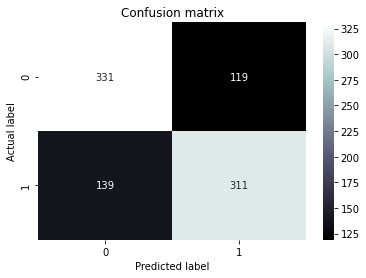

acc:  0.7133333333333334


In [206]:
Y_pred = best_model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [43]:
y_pred

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,

In [44]:
np.argmax(test_y,axis=1)

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,

In [45]:
fn_result = []
fp_result = []
for n in range(0, len(test_y)):
    if y_pred[n] != np.argmax(test_y,axis=1)[n]:
        if(y_pred[n] == 1) :
            fp_result.append(n)
        else :
            fn_result.append(n)

NameError: name 'test_y' is not defined

In [46]:
print(len(fp_result))
print(len(fn_result))

47
16


In [47]:
for name in fp_result:
    print(test_file[name])

data/final/test_negative/0.17_bg_739_1.wav
data/final/test_negative/0.11_bg_969_30.wav
data/final/test_negative/0.88_bg_602_45.wav
data/final/test_negative/0.37_bg_1060_44.wav
data/final/test_negative/0.01_bg_861_44.wav
data/final/test_negative/0.46_bg_779_30.wav
data/final/test_negative/0.48_bg_881_15.wav
data/final/test_negative/0.57_bg_869_8.wav
data/final/test_negative/0.14_bg_650_32.wav
data/final/test_negative/0.29_bg_712_34.wav
data/final/test_negative/0.65_bg_769_22.wav
data/final/test_negative/0.06_bg_1005_13.wav
data/final/test_negative/0.03_bg_992_7.wav
data/final/test_negative/0.07_bg_849_35.wav
data/final/test_negative/0.13_bg_853_37.wav
data/final/test_negative/0.84_bg_785_34.wav
data/final/test_negative/0.68_bg_795_43.wav
data/final/test_negative/0.05_bg_715_36.wav
data/final/test_negative/0.33_bg_584_33.wav
data/final/test_negative/0.14_bg_728_42.wav
data/final/test_negative/0.14_bg_631_23.wav
data/final/test_negative/0.53_bg_770_23.wav
data/final/test_negative/0.53_bg_

In [48]:
import IPython.display

In [49]:
i = 0
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/final/test_negative/0.17_bg_739_1.wav
1


In [ ]:
i = 1
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [ ]:
i = 2
wav = test_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [50]:
for name in fn_result:
    print(test_file[name])

data/final/test/0.24_bg_524_m3.wav
data/final/test/0.24_bg_1_dh1.wav
data/final/test/0.19_bg_467_dh26.wav
data/final/test/0.49_bg_189_dh1.wav
data/final/test/0.3_bg_466_dh25.wav
data/final/test/0.19_bg_361_dh11.wav
data/final/test/0.39_bg_209_dh25.wav
data/final/test/0.19_bg_21_dh26.wav
data/final/test/0.52_bg_23_dj12.wav
data/final/test/0.41_bg_75_dh27.wav
data/final/test/0.43_bg_62_dh16.wav
data/final/test/0.13_bg_74_dh26.wav
data/final/test/0.23_bg_299_dh27.wav
data/final/test/0.26_bg_179_f2.wav
data/final/test/0.24_bg_53_dh1.wav
data/final/test/0.66_bg_108_dh18.wav


In [55]:
i = -1
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/final/test/0.66_bg_108_dh18.wav
0


In [ ]:
i = 1
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [ ]:
i = 2
wav = test_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(test_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

In [68]:
NON_DATA_DIR = 'data/final_test/test_negative/'

extra_fire_X = []
extra_fire_spectrograms = []
extra_fire_mel_spectrograms = []
extra_fire_mfccs = []
extra_fire_y = []
extra_fire_file = []

for fname in os.listdir(NON_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        extra_fire_file.append(NON_DATA_DIR + fname)
        wav, sr = librosa.load(NON_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        extra_fire_mfccs.append(padded_mfcc)
        extra_fire_mel_spectrograms.append(padded_mel_spectrogram)
        extra_fire_y.append(0)
    except Exception as e:
        print(fname, e)
        raise

In [69]:
extra_fire_DATA_DIR = 'data/final_test/test/'

for fname in os.listdir(extra_fire_DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        extra_fire_file.append(extra_fire_DATA_DIR + fname)
        wav, sr = librosa.load(extra_fire_DATA_DIR + fname, sr=16000)
        
        mfcc = librosa.feature.mfcc(wav, sr=16000)
        mfcc_normalize = librosa.util.normalize(mfcc,norm=None)
        padded_mfcc = padding(mfcc_normalize, 63)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = padding(mel_spectogram, 63)
        
        extra_fire_mfccs.append(padded_mfcc)
        extra_fire_mel_spectrograms.append(padded_mel_spectrogram)
        extra_fire_y.append(1)
    except Exception as e:
        print(fname, e)
        raise
        
extra_fire_mfccs = np.array(extra_fire_mfccs)
extra_fire_mel_spectrograms = np.array(extra_fire_mel_spectrograms)
extra_fire_y = np.array(extra_fire_y)
extra_fire_y = to_categorical(np.array(extra_fire_y))

extra_fire_X_ex = np.expand_dims(extra_fire_mfccs, -1)
extra_fire_X_ex_mel = np.expand_dims(extra_fire_mel_spectrograms, -1)

In [70]:
extra_fire_X_ex.shape

(900, 20, 63, 1)

In [71]:
np.save(os.path.join("data/dataset", "extra_fire_X_ex.npy"), extra_fire_X_ex)
np.save(os.path.join("data/dataset", "extra_fire_X_ex_mel.npy"), extra_fire_X_ex_mel)
np.save(os.path.join("data/dataset", "extra_fire_file.npy"), extra_fire_file)
np.save(os.path.join("data/dataset", "extra_fire_y.npy"), np.array(extra_fire_y))

In [72]:
extra_fire_X_ex = np.load(os.path.join('data/dataset', 'extra_fire_X_ex.npy'))
extra_fire_X_ex_mel = np.load(os.path.join('data/dataset', 'extra_fire_X_ex_mel.npy'))
extra_fire_file = np.load(os.path.join('data/dataset', 'extra_fire_file.npy'))
extra_fire_y = np.load(os.path.join('data/dataset', 'extra_fire_y.npy'))

extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file = shuffle(extra_fire_X_ex, extra_fire_X_ex_mel, extra_fire_y, extra_fire_file, random_state=1523)

In [74]:
best_model = models.load_model('model/train_X_ex_best.h5')

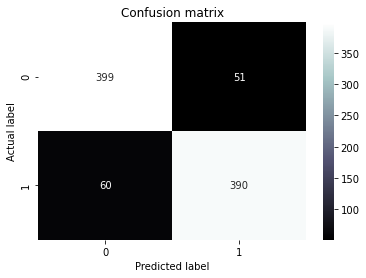

acc:  0.8766666666666667


In [75]:
#mfcc
Y_pred = model.predict(extra_fire_X_ex)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

In [76]:
y_pred

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,

In [77]:
fn_result = []
fp_result = []
for n in range(0, len(extra_fire_y)):
    if y_pred[n] != np.argmax(extra_fire_y,axis=1)[n]:
        if(y_pred[n] == 0) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [78]:
print(len(fp_result))
print(len(fn_result))

60
51


In [90]:
for name in fn_result:
    print(extra_fire_file[name])

data/final_test/test_negative/0.36_0.12025secs_bg_438_1.wav
data/final_test/test_negative/0.7_0.2800625secs_bg_3426_40.wav
data/final_test/test_negative/0.52_0.0165625secs_bg_371_1.wav
data/final_test/test_negative/0.66_0.3864375secs_bg_2632_40.wav
data/final_test/test_negative/0.26_1.0145secs_bg_3381_1.wav
data/final_test/test_negative/0.2_0.2928125secs_bg_2599_2.wav
data/final_test/test_negative/0.41_0.7153125secs_bg_420_2.wav
data/final_test/test_negative/0.22_0.6000625secs_bg_3296_3.wav
data/final_test/test_negative/0.8_0.8279375secs_bg_2584_3.wav
data/final_test/test_negative/0.44_0.626375secs_bg_3288_40.wav
data/final_test/test_negative/0.12_0.198875secs_bg_3382_2.wav
data/final_test/test_negative/0.2_0.5111875secs_bg_2587_1.wav
data/final_test/test_negative/0.02_0.130125secs_bg_3373_2.wav
data/final_test/test_negative/0.46_0.704375secs_bg_2588_2.wav
data/final_test/test_negative/0.07_0.8404375secs_bg_2589_23.wav
data/final_test/test_negative/0.9_0.8118125secs_bg_2585_40.wav
data

In [95]:
import shutil

for file in fn_result:
    shutil.copy(extra_fire_file[file], 'data/false/'+extra_fire_file[file][30:])

In [94]:
extra_fire_file[name][30:]

'0.58_0.70375secs_bg_335_3.wav'

In [54]:
for name in fn_result:
    print(extra_fire_file[name])

data/final_test/test_negative/0.73_0.0008125secs_bg_426_40.wav
data/final_test/test_negative/0.1_0.0796875secs_bg_3296_3.wav
data/final_test/test_negative/0.9_0.02375secs_bg_2625_1.wav
data/final_test/test_negative/0.18_0.5736875secs_bg_2757_45.wav
data/final_test/test_negative/0.16_0.1006875secs_bg_326_3.wav
data/final_test/test_negative/0.53_0.1925secs_bg_2623_40.wav
data/final_test/test_negative/0.22_0.0501875secs_bg_354_23.wav
data/final_test/test_negative/0.32_0.8355625secs_bg_329_1.wav
data/final_test/test_negative/0.21_0.00625secs_bg_381_45.wav
data/final_test/test_negative/0.81_0.690875secs_bg_3215_40.wav
data/final_test/test_negative/0.6_0.01525secs_bg_2567_40.wav
data/final_test/test_negative/0.4_0.8509375secs_bg_2616_1.wav
data/final_test/test_negative/0.48_0.3015625secs_bg_3417_40.wav
data/final_test/test_negative/0.09_0.6753125secs_bg_3269_40.wav
data/final_test/test_negative/0.2_0.1915secs_bg_3253_1.wav
data/final_test/test_negative/0.14_1.066375secs_bg_331_23.wav
data/fi

In [145]:
best_model = models.load_model('model/train_X_ex_mel_best.h5')

In [46]:
#mel spectrogram
Y_pred = best_model.predict(extra_fire_X_ex_mel)
y_pred = np.argmax(Y_pred,axis=1)

tn, fp, fn, tp = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred).ravel()
matrix = confusion_matrix(np.argmax(extra_fire_y,axis=1), y_pred)
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="bone" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print('acc: ', (tn+tp)/(tn+fp+fn+tp))

NameError: name 'best_model' is not defined

In [147]:
fn_result = []
fp_result = []
for n in range(0, len(extra_fire_y)):
    if y_pred[n] != np.argmax(extra_fire_y,axis=1)[n]:
        if(y_pred[n] == 0) :
            fp_result.append(n)
        else :
            fn_result.append(n)

In [148]:
print(len(fp_result))
print(len(fn_result))

41
2


In [97]:
for name in fp_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [96]:
i = 0
wav = extra_fire_file[fp_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(extra_fire_file[fp_result[i]])
print(y_pred[fp_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/resampling/fire/dh17.wav
0


In [98]:
for name in fn_result:
    print(extra_fire_file[name])

data/resampling/non/2.wav
data/resampling/non/3.wav
data/resampling/non/34.wav
data/resampling/non/43.wav
data/resampling/non/6.wav


In [100]:
i = 2
wav = extra_fire_file[fn_result[i]]
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)
print(extra_fire_file[fn_result[i]])
print(y_pred[fn_result[i]])
IPython.display.Audio(data=y[:20000], rate=sr)

wav shape:  (13933,)
data/resampling/non/34.wav
1


In [ ]:
y_pred

In [9]:
wav = 'non_tang.wav'
file_sr = librosa.get_samplerate(wav)

y, sr = librosa.load(wav, sr=file_sr)
print('wav shape: ', y.shape)

wav shape:  (16030,)


In [13]:
#mfcc = librosa.feature.mfcc(y, sr=16000)
#padded_mfcc = pad2d(mfcc, 75)
mel_spectogram = librosa.feature.melspectrogram(y)
padded_mel_spectrogram = pad2d(mel_spectogram, 75)

In [14]:
test_mel_tang = np.array(padded_mel_spectrogram)
test_final = []
test_final.append(test_mel_tang)
test_final = np.expand_dims(test_final, -1)

In [15]:
test_final

(1, 128, 75, 1)

In [16]:
test_X_ex_mel.shape

(300, 128, 50, 1)

In [ ]:
Y_pred = model.predict(test_final)
y_pred = np.argmax(Y_pred,axis=1)

In [ ]:
y_pred